<a href="https://colab.research.google.com/github/MarcVodoleev/LFVU/blob/main/LFVU_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-dimension git+https://github.com/IlyaTrofimov/RTD.git git+https://github.com/simonzhang00/ripser-plusplus.git

  Cloning https://github.com/IlyaTrofimov/RTD.git to /tmp/pip-req-build-21e2vgrk
  Running command git clone --filter=blob:none --quiet https://github.com/IlyaTrofimov/RTD.git /tmp/pip-req-build-21e2vgrk
  Resolved https://github.com/IlyaTrofimov/RTD.git to commit f47c99e4784173b8b43441b61f71f9d585f85d52
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/simonzhang00/ripser-plusplus.git to /tmp/pip-req-build-z5wrvt2l
  Running command git clone --filter=blob:none --quiet https://github.com/simonzhang00/ripser-plusplus.git /tmp/pip-req-build-z5wrvt2l
  Resolved https://github.com/simonzhang00/ripser-plusplus.git to commit 30243c0c752de26d7fdf6e41f08bf7b840ca4744
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00
  Created wheel for rtd: filename=rtd-1.0-py3-none-any.whl size=10217 sha256=fc05815a14fb9aea7f6375d8a168ce830ac46d81501d07b93b76f7

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.neighbors import NearestNeighbors
from typing import Tuple, Optional

class LFVULoss(nn.Module):
    """
    Local Fraction of Variance Unexplained (LFVU) Loss
    Measures preservation of local neighborhood structure
    """
    def __init__(self, k: int = 10, alpha: float = 1.0):
        """
        Args:
            k: Number of nearest neighbors to consider
            alpha: Weight for LFVU loss
        """
        super().__init__()
        self.k = k
        self.alpha = alpha

    def compute_pairwise_distances(self, X: torch.Tensor) -> torch.Tensor:
        """Compute pairwise Euclidean distances"""
        # X: [batch_size, dim]
        X_norm = (X ** 2).sum(dim=1, keepdim=True)
        distances = X_norm + X_norm.t() - 2 * torch.mm(X, X.t())
        distances = torch.clamp(distances, min=0.0)  # Ensure non-negative
        return torch.sqrt(distances + 1e-8)  # Add small epsilon for stability

    def normalize_distances(self, distances: torch.Tensor) -> torch.Tensor:
        """Normalize distances as in LFVU formula"""
        # distances: [batch_size, k] distances to k-nearest neighbors
        mean_dist = distances.mean(dim=1, keepdim=True)
        std_dist = distances.std(dim=1, keepdim=True) + 1e-8

        # Normalize: subtract mean and divide by std (like z-score)
        normalized = (distances - mean_dist) / std_dist
        return normalized

    def get_knn_distances(self, X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get distances to k-nearest neighbors and their indices
        Returns:
            - knn_distances: [batch_size, k] distances to k-nearest neighbors
            - knn_indices: [batch_size, k] indices of k-nearest neighbors
        """
        batch_size = X.shape[0]

        # Compute pairwise distances
        pairwise_dist = self.compute_pairwise_distances(X)

        # Get k+1 neighbors (including self)
        k_neighbors = min(self.k + 1, batch_size)
        knn_dist, knn_idx = torch.topk(pairwise_dist, k=k_neighbors,
                                      dim=1, largest=False, sorted=True)

        # Remove self (distance 0) if present
        if k_neighbors > 1:
            knn_dist = knn_dist[:, 1:]  # Remove self
            knn_idx = knn_idx[:, 1:]    # Remove self
        else:
            knn_dist = torch.zeros((batch_size, 1), device=X.device)
            knn_idx = torch.zeros((batch_size, 1), device=X.device, dtype=torch.long)

        return knn_dist, knn_idx

    def forward(self, X_original: torch.Tensor, X_latent: torch.Tensor) -> torch.Tensor:
        """
        Compute LFVU loss

        Args:
            X_original: Original high-dimensional data [batch_size, input_dim]
            X_latent: Latent representation [batch_size, latent_dim]

        Returns:
            LFVU loss value
        """
        batch_size = X_original.shape[0]

        # Get k-nearest neighbors in original space
        d_dist, d_idx = self.get_knn_distances(X_original)

        # Get distances to same neighbors in latent space
        # We need to compute distances between each point and its k-nearest neighbors
        r_dist = []
        for i in range(batch_size):
            # Get indices of neighbors for point i
            neighbor_indices = d_idx[i]

            # Compute distances from point i to its neighbors in latent space
            point_latent = X_latent[i:i+1]  # [1, latent_dim]
            neighbors_latent = X_latent[neighbor_indices]  # [k, latent_dim]

            # Compute Euclidean distances
            dist = torch.norm(point_latent - neighbors_latent, dim=1)
            r_dist.append(dist)

        r_dist = torch.stack(r_dist)  # [batch_size, k]

        # Normalize distances
        d_norm = self.normalize_distances(d_dist)
        r_norm = self.normalize_distances(r_dist)

        # Compute LFVU for each point
        numerator = torch.sum((d_norm - r_norm) ** 2, dim=1)  # [batch_size]
        denominator = torch.sum((d_norm - d_norm.mean(dim=1, keepdim=True)) ** 2, dim=1)  # [batch_size]

        # Avoid division by zero
        denominator = torch.clamp(denominator, min=1e-8)

        # LFVU for each point
        lfvu_per_point = numerator / denominator

        # Average LFVU across batch
        lfvu_loss = lfvu_per_point.mean()

        return self.alpha * lfvu_loss


class Autoencoder(nn.Module):
    """Basic Autoencoder architecture"""
    def __init__(self, input_dim: int, latent_dim: int,
                 hidden_dims: list = [512, 256, 128]):
        super().__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim

        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder (reverse architecture)
        decoder_layers = []
        hidden_dims_rev = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for hidden_dim in hidden_dims_rev:
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim

        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


class LFVU_AE(nn.Module):
    """
    LFVU-Autoencoder: Autoencoder with LFVU loss
    Similar to RTD-AE but using LFVU instead of RTD
    """
    def __init__(self, input_dim: int, latent_dim: int,
                 lfvu_k: int = 10, lfvu_weight: float = 1.0,
                 hidden_dims: list = [512, 256, 128]):
        super().__init__()

        self.autoencoder = Autoencoder(input_dim, latent_dim, hidden_dims)
        self.lfvu_loss = LFVULoss(k=lfvu_k, alpha=lfvu_weight)

    def forward(self, x):
        x_recon, z = self.autoencoder(x)
        return x_recon, z

    def compute_loss(self, x, x_recon, z,
                    recon_weight: float = 1.0,
                    lfvu_weight: float = 1.0) -> Tuple[torch.Tensor, dict]:
        """
        Compute combined loss: reconstruction + LFVU

        Args:
            x: Original input
            x_recon: Reconstructed input
            z: Latent representation
            recon_weight: Weight for reconstruction loss
            lfvu_weight: Weight for LFVU loss

        Returns:
            total_loss, loss_dict
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x_recon, x)

        # LFVU loss
        lfvu_loss_value = self.lfvu_loss(x, z)

        # Combined loss
        total_loss = recon_weight * recon_loss + lfvu_weight * lfvu_loss_value

        # Return loss dictionary for monitoring
        loss_dict = {
            'total': total_loss.item(),
            'recon': recon_loss.item(),
            'lfvu': lfvu_loss_value.item(),
            'recon_weighted': (recon_weight * recon_loss).item(),
            'lfvu_weighted': (lfvu_weight * lfvu_loss_value).item()
        }

        return total_loss, loss_dict


class LFVU_AETrainer:
    """Training wrapper for LFVU-AE"""
    def __init__(self, model, lr: float = 1e-3, device: str = 'cuda'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=10, factor=0.75
        )

    def train_step(self, x_batch):
        self.model.train()
        self.optimizer.zero_grad()

        x_batch = x_batch.to(self.device)
        x_recon, z = self.model(x_batch)

        # Two-phase training like RTD-AE:
        # Phase 1: Only reconstruction (first few epochs)
        # Phase 2: Reconstruction + LFVU

        # For simplicity, we'll use combined loss with weights
        # In practice, you might want to implement the two-phase training
        # from the RTD-AE paper
        loss, loss_dict = self.model.compute_loss(
            x_batch, x_recon, z,
            recon_weight=1.0,
            lfvu_weight=1.0  # Can be adjusted or made 0 for phase 1
        )

        loss.backward()
        self.optimizer.step()

        return loss_dict

    def validate(self, x_batch):
        self.model.eval()
        with torch.no_grad():
            x_batch = x_batch.to(self.device)
            x_recon, z = self.model(x_batch)
            loss, loss_dict = self.model.compute_loss(
                x_batch, x_recon, z,
                recon_weight=1.0,
                lfvu_weight=1.0
            )
        return loss_dict

    def train(self, train_loader, val_loader, epochs: int,
              lfvu_start_epoch: int = 200):
        """
        Train with two-phase approach similar to RTD-AE

        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            epochs: Total training epochs
            lfvu_start_epoch: Epoch to start adding LFVU loss (like RTD-AE)
        """
        train_history = []
        val_history = []

        for epoch in range(epochs):
            # Phase-based training
            if epoch < lfvu_start_epoch:
                # Phase 1: Only reconstruction
                lfvu_weight = 0.0
            else:
                # Phase 2: Reconstruction + LFVU
                lfvu_weight = 0.05

            # Training
            epoch_train_losses = []
            for batch in train_loader:
                if isinstance(batch, (list, tuple)):
                    x_batch = batch[0]
                else:
                    x_batch = batch

                # Update LFVU weight in model
                self.model.lfvu_loss.alpha = lfvu_weight

                loss_dict = self.train_step(x_batch)
                epoch_train_losses.append(loss_dict['total'])

            # Validation
            epoch_val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    if isinstance(batch, (list, tuple)):
                        x_batch = batch[0]
                    else:
                        x_batch = batch

                    val_dict = self.validate(x_batch)
                    epoch_val_losses.append(val_dict['total'])

            # Record history
            train_history.append(np.mean(epoch_train_losses))
            val_history.append(np.mean(epoch_val_losses))

            # Update learning rate
            self.scheduler.step(np.mean(epoch_val_losses))

            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}: "
                      f"Train Loss: {train_history[-1]:.4f}, "
                      f"Train Recon Loss: {loss_dict['recon']:.4f}, "
                      f"Train Mean LFVU: {loss_dict['lfvu']:.4f}, \n"
                      f"Val Loss: {val_history[-1]:.4f}, "
                      f"Val Recon Loss: {val_dict['recon']:.4f}, "
                      f"Val Mean LFVU: {val_dict['lfvu']:.4f}, "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.6f}, "
                      f"LFVU Weight: {lfvu_weight}")

        return train_history, val_history


# Example usage
def create_lfvu_ae(input_dim=784, latent_dim=2, lfvu_k=10):
    """Create LFVU-AE model for MNIST-like data"""
    model = LFVU_AE(
        input_dim=input_dim,
        latent_dim=latent_dim,
        lfvu_k=lfvu_k,
        lfvu_weight=1.0,
        hidden_dims=[512, 256, 128]
    )
    return model


def create_lfvu_ae_for_high_dim(input_dim=16384, latent_dim=16, lfvu_k=10):
    """Create LFVU-AE model for high-dimensional data (like COIL-20)"""
    model = LFVU_AE(
        input_dim=input_dim,
        latent_dim=latent_dim,
        lfvu_k=lfvu_k,
        lfvu_weight=1.0,
        hidden_dims=[2048, 1024, 512, 256]  # Deeper for high-dim data
    )
    return model


# Training example
# if __name__ == "__main__":
#     # Example with synthetic data
#     batch_size = 64
#     input_dim = 100
#     latent_dim = 2

#     # Create synthetic data
#     X_train = torch.randn(1000, input_dim)
#     X_val = torch.randn(200, input_dim)

#     # Create data loaders
#     train_loader = torch.utils.data.DataLoader(
#         torch.utils.data.TensorDataset(X_train),
#         batch_size=batch_size,
#         shuffle=True
#     )

#     val_loader = torch.utils.data.DataLoader(
#         torch.utils.data.TensorDataset(X_val),
#         batch_size=batch_size
#     )

#     # Create model
#     model = create_lfvu_ae(input_dim, latent_dim, lfvu_k=10)
#     trainer = LFVU_AETrainer(model, lr=1e-3, device='cuda')

#     # Train
#     train_history, val_history = trainer.train(
#         train_loader, val_loader,
#         epochs=100,
#         lfvu_start_epoch=50
#     )

#     print("Training complete!")

Epoch 10/100: Train Loss: 0.0649, Train Recon Loss: 0.0645, Train Mean LFVU: 0.0000, 
Val Loss: 0.0561, Val Recon Loss: 0.0553, Val Mean LFVU: 0.0000, LR: 0.001000, LFVU Weight: 0.0
Epoch 20/100: Train Loss: 0.0563, Train Recon Loss: 0.0557, Train Mean LFVU: 0.0000, 
Val Loss: 0.0515, Val Recon Loss: 0.0507, Val Mean LFVU: 0.0000, LR: 0.001000, LFVU Weight: 0.0
Epoch 30/100: Train Loss: 0.1091, Train Recon Loss: 0.0558, Train Mean LFVU: 0.0544, 
Val Loss: 0.1028, Val Recon Loss: 0.0489, Val Mean LFVU: 0.0521, LR: 0.001000, LFVU Weight: 0.05
Epoch 40/100: Train Loss: 0.1051, Train Recon Loss: 0.0508, Train Mean LFVU: 0.0525, 
Val Loss: 0.1011, Val Recon Loss: 0.0476, Val Mean LFVU: 0.0526, LR: 0.000750, LFVU Weight: 0.05
Epoch 50/100: Train Loss: 0.1022, Train Recon Loss: 0.0496, Train Mean LFVU: 0.0500, 
Val Loss: 0.1003, Val Recon Loss: 0.0470, Val Mean LFVU: 0.0521, LR: 0.000563, LFVU Weight: 0.05
Epoch 60/100: Train Loss: 0.1013, Train Recon Loss: 0.0492, Train Mean LFVU: 0.0532, 
V

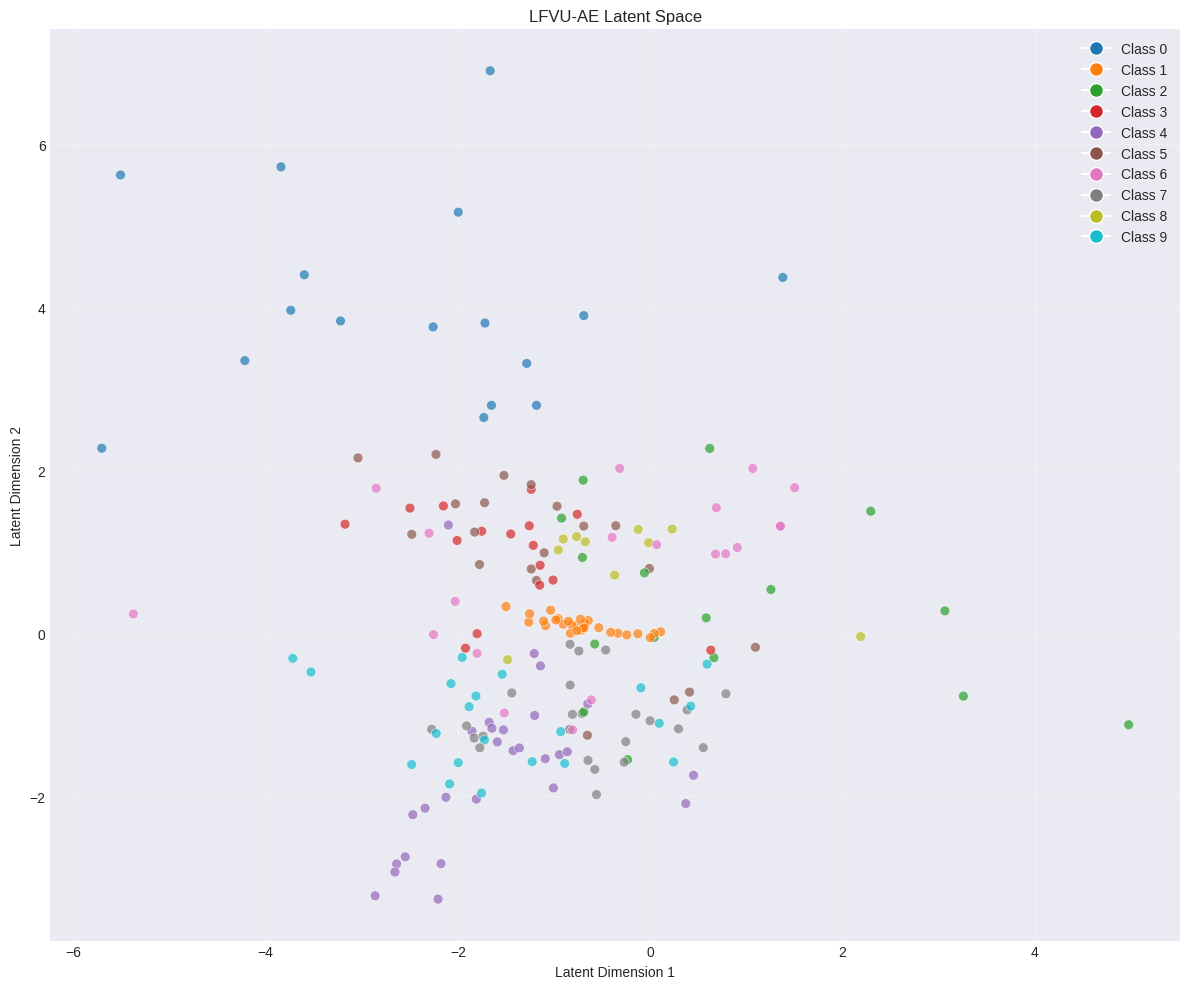

2. Comparing with baseline methods...


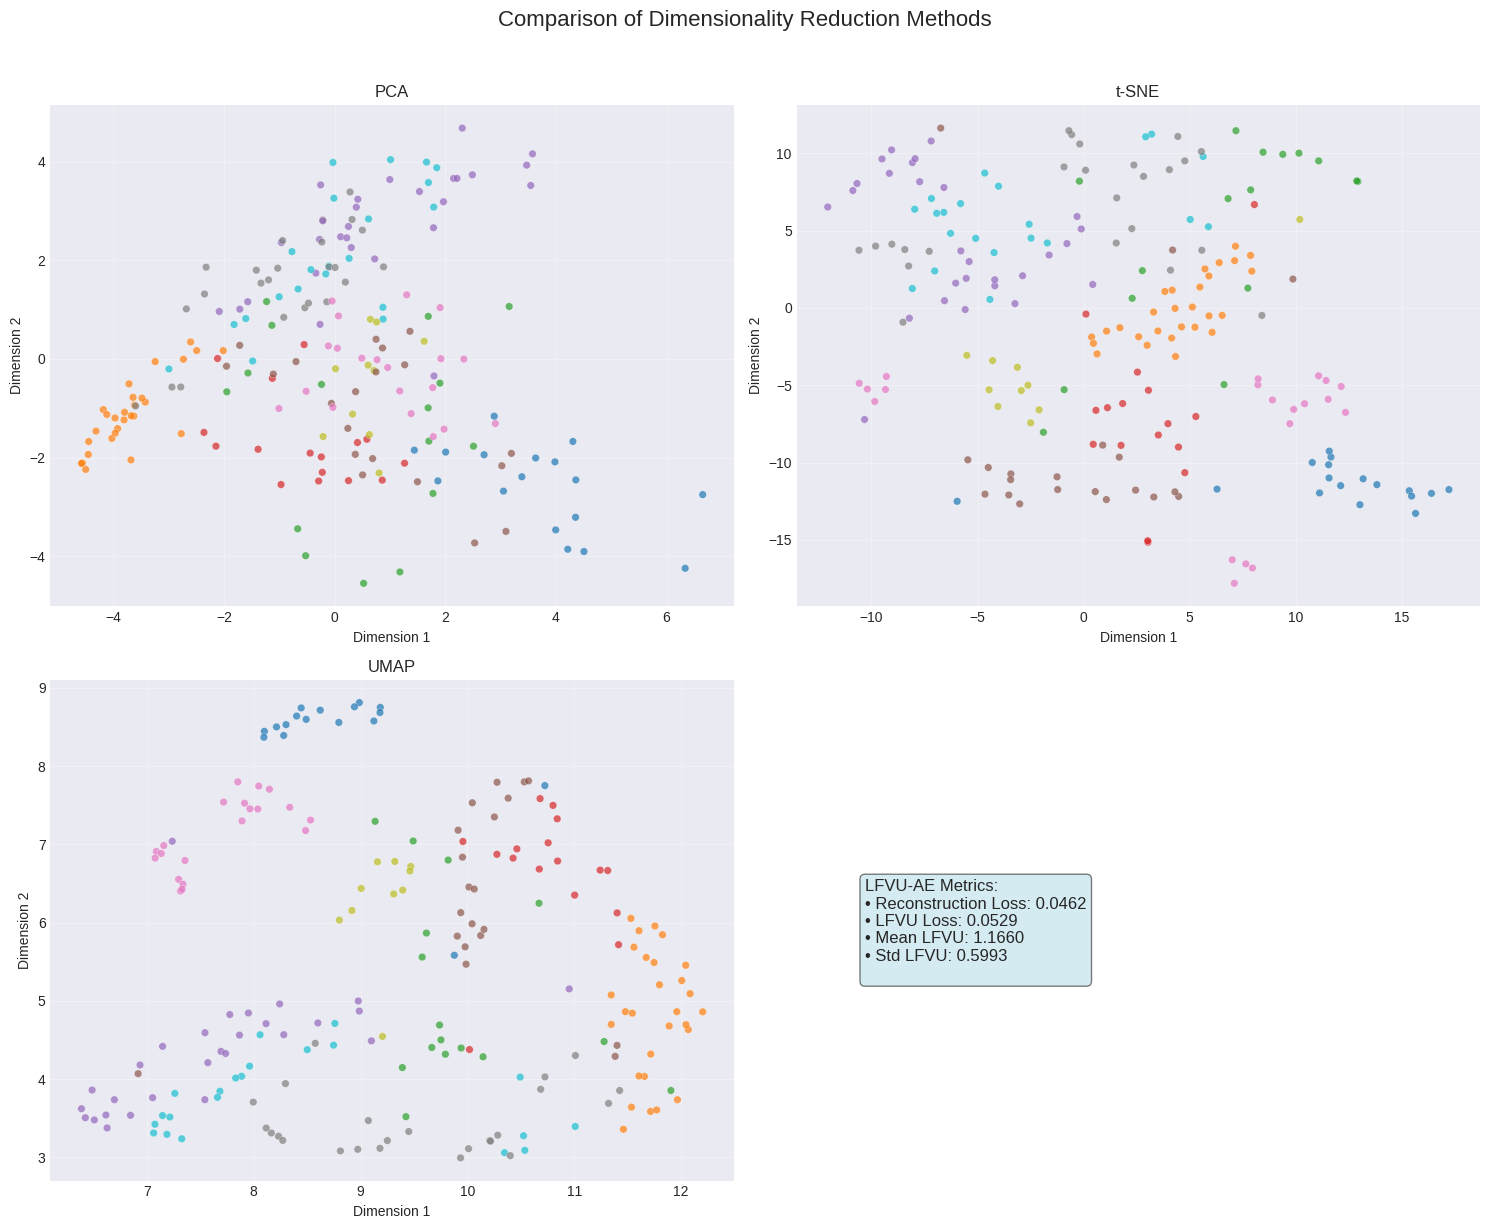

3. Analyzing LFVU distribution...


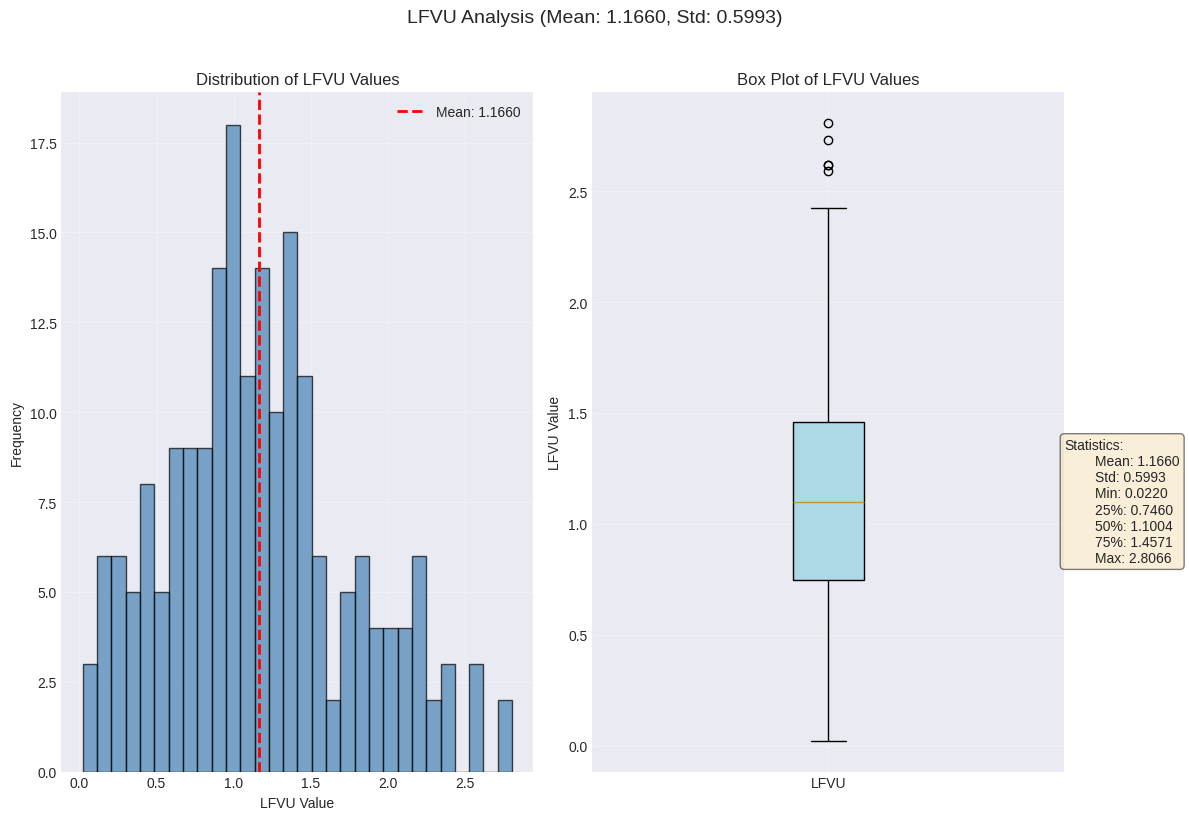

4. Visualizing neighborhood preservation...


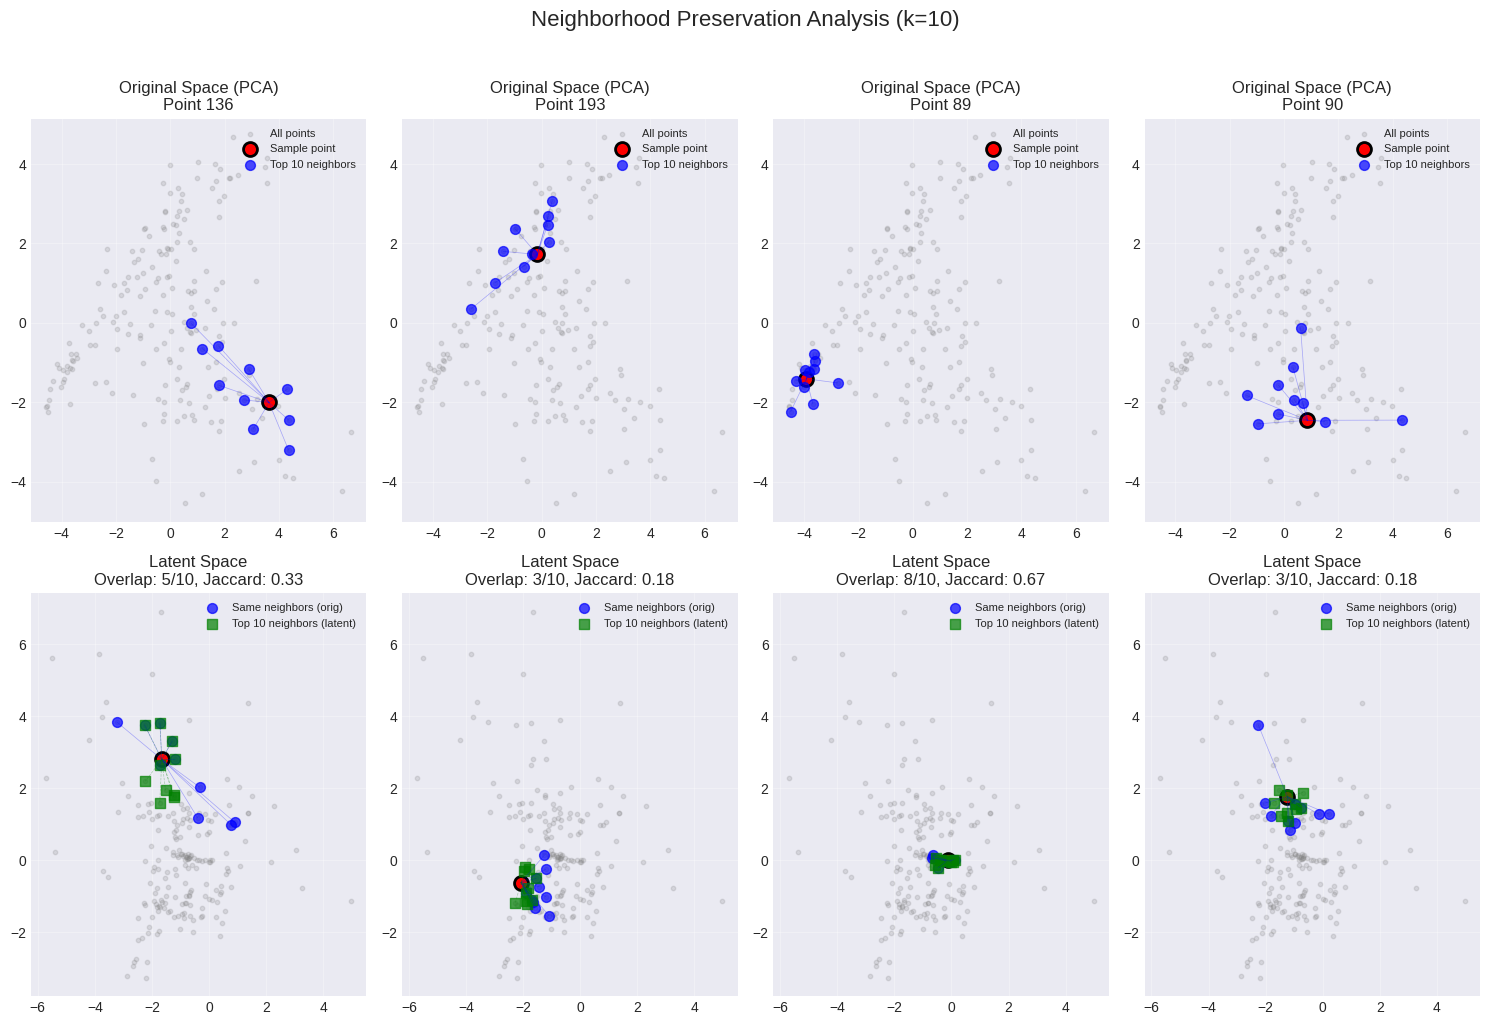

5. Analyzing distance correlation...


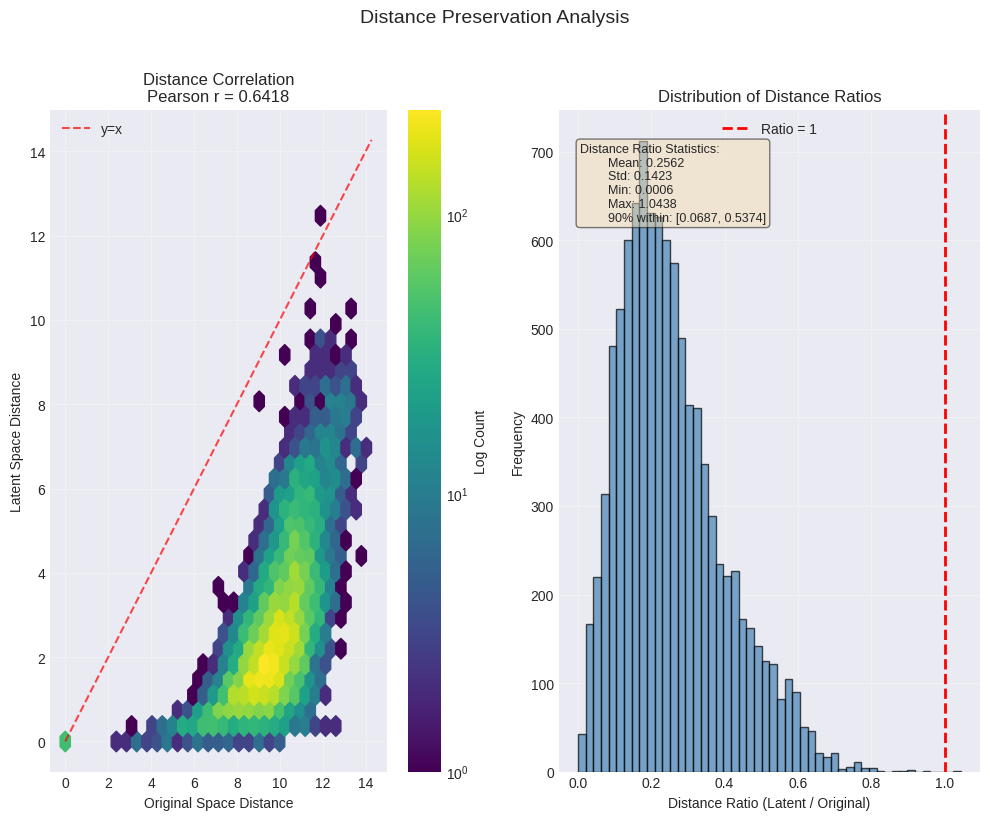

6. Computing metrics...

Report generated in ./lfvu_ae_report_mnist/
Distance correlation: 0.6418
Mean LFVU: 1.1660
Reconstruction loss: 0.0462


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from scipy.spatial.distance import cdist
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')
from umap import UMAP

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class LFVU_AE_Visualizer:
    """Visualization tools for LFVU-AE results"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device

    def get_latent_representations(self, X: torch.Tensor) -> np.ndarray:
        """Extract latent representations"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = X.to(self.device)
            _, z = self.model(X_tensor)
            return z.cpu().numpy()

    def get_reconstructions(self, X: torch.Tensor) -> np.ndarray:
        """Get reconstructed data"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = X.to(self.device)
            x_recon, _ = self.model(X_tensor)
            return x_recon.cpu().numpy()

    def plot_latent_space(self, X: torch.Tensor, labels: Optional[np.ndarray] = None,
                         title: str = "LFVU-AE Latent Space",
                         figsize: Tuple[int, int] = (12, 10),
                         save_path: Optional[str] = None):
        """Plot 2D or 3D latent space visualization"""

        # Get latent representations
        Z = self.get_latent_representations(X)
        latent_dim = Z.shape[1]

        if labels is None:
            labels = np.zeros(len(Z))

        # Create DataFrame for easier plotting
        df = pd.DataFrame(Z, columns=[f'z{i+1}' for i in range(latent_dim)])
        df['label'] = labels
        df['label_str'] = df['label'].astype(str)

        if latent_dim == 2:
            # 2D scatter plot
            fig, ax = plt.subplots(figsize=figsize)

            if len(np.unique(labels)) <= 10:
                # Color by discrete labels
                scatter = ax.scatter(Z[:, 0], Z[:, 1], c=labels, cmap='tab10',
                                    alpha=0.7, s=50, edgecolors='w', linewidth=0.5)

                # Add legend for discrete labels
                unique_labels = np.unique(labels)
                handles = [plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=plt.cm.tab10(i/len(unique_labels)),
                                     markersize=10) for i in range(len(unique_labels))]
                ax.legend(handles, [f'Class {l}' for l in unique_labels])
            else:
                # Color by value if many classes
                scatter = ax.scatter(Z[:, 0], Z[:, 1], c=labels, cmap='viridis',
                                    alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
                plt.colorbar(scatter, ax=ax, label='Label Value')

            ax.set_xlabel('Latent Dimension 1')
            ax.set_ylabel('Latent Dimension 2')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)

        elif latent_dim == 3:
            # 3D scatter plot
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')

            scatter = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
                                c=labels, cmap='tab10',
                                alpha=0.7, s=30, edgecolors='w', linewidth=0.3)

            ax.set_xlabel('Latent Dimension 1')
            ax.set_ylabel('Latent Dimension 2')
            ax.set_zlabel('Latent Dimension 3')
            ax.set_title(title)

            # Add colorbar
            if len(np.unique(labels)) > 1:
                cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
                cbar.set_label('Class')

        else:
            # For higher dimensions, use PCA to reduce to 2D for visualization
            print(f"Latent dimension is {latent_dim}. Using PCA for 2D visualization.")
            pca = PCA(n_components=2)
            Z_2d = pca.fit_transform(Z)

            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap='tab10',
                               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)

            ax.set_xlabel('PCA Component 1')
            ax.set_ylabel('PCA Component 2')
            ax.set_title(f"{title} (PCA Projection)")
            ax.grid(True, alpha=0.3)

            # Add explained variance ratio
            var_ratio = pca.explained_variance_ratio_
            ax.text(0.02, 0.98, f'Explained Variance: {var_ratio[0]:.2%} + {var_ratio[1]:.2%} = {sum(var_ratio):.2%}',
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        plt.tight_layout()
        plt.show()

        return Z

    def plot_comparison_with_baselines(self, X: torch.Tensor, labels: Optional[np.ndarray] = None,
                                      figsize: Tuple[int, int] = (15, 12),
                                      save_path: Optional[str] = None):
        """Compare LFVU-AE with other dimensionality reduction methods"""

        X_np = X.cpu().numpy() if isinstance(X, torch.Tensor) else X

        # Get LFVU-AE latent space
        Z_lfvu = self.get_latent_representations(torch.FloatTensor(X_np))

        # Apply other methods for comparison
        methods = {
            'PCA': PCA(n_components=2),
            't-SNE': TSNE(n_components=2, perplexity=30, random_state=42),
            'UMAP': UMAP(n_components=2, random_state=42)
        }

        if labels is None:
            labels = np.zeros(len(X_np))

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()

        # Plot each method
        for idx, (method_name, method) in enumerate(methods.items()):
            ax = axes[idx]

            if method_name == 'LFVU-AE':
                if Z_lfvu.shape[1] > 2:
                    # Use PCA for visualization if needed
                    pca = PCA(n_components=2)
                    Z_vis = pca.fit_transform(Z_lfvu)
                    ax.set_title(f"{method_name} (PCA projection)")
                else:
                    Z_vis = Z_lfvu
                    ax.set_title(method_name)
            else:
                Z_vis = method.fit_transform(X_np)
                ax.set_title(method_name)

            scatter = ax.scatter(Z_vis[:, 0], Z_vis[:, 1],
                                c=labels, cmap='tab10',
                                alpha=0.7, s=30, edgecolors='w', linewidth=0.3)

            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            ax.grid(True, alpha=0.3)

        # Add LFVU-AE metrics in the last subplot
        ax = axes[-1]
        ax.axis('off')

        # Compute metrics for LFVU-AE
        metrics = self.compute_metrics(torch.FloatTensor(X_np))

        metrics_text = "LFVU-AE Metrics:\n"
        metrics_text += f"• Reconstruction Loss: {metrics['recon_loss']:.4f}\n"
        metrics_text += f"• LFVU Loss: {metrics['lfvu_loss']:.4f}\n"
        metrics_text += f"• Mean LFVU: {metrics['mean_lfvu']:.4f}\n"
        metrics_text += f"• Std LFVU: {metrics['std_lfvu']:.4f}\n"
        if 'cluster_separation' in metrics:
            metrics_text += f"• Cluster Separation: {metrics['cluster_separation']:.4f}"

        ax.text(0.1, 0.5, metrics_text, fontsize=12,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

        plt.suptitle("Comparison of Dimensionality Reduction Methods", fontsize=16, y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def compute_metrics(self, X: torch.Tensor) -> Dict:
        """Compute evaluation metrics for LFVU-AE"""
        self.model.eval()

        with torch.no_grad():
            X_tensor = X.to(self.device)
            x_recon, z = self.model(X_tensor)

            # Reconstruction loss
            recon_loss = torch.nn.functional.mse_loss(x_recon, X_tensor).item()

            # LFVU loss
            lfvu_loss = self.model.lfvu_loss(X_tensor, z).item()

            # Compute LFVU per point
            X_np = X_tensor.cpu().numpy()
            Z_np = z.cpu().numpy()

            # Compute pairwise distances
            X_dist = pairwise_distances(X_np)
            Z_dist = pairwise_distances(Z_np)

            # Compute LFVU for each point (k=10)
            k = min(10, len(X_np) - 1)
            lfvu_values = []

            for i in range(len(X_np)):
                # Get k nearest neighbors in original space
                idx_orig = np.argsort(X_dist[i])[1:k+1]
                # Get distances to same neighbors in latent space
                d_i = X_dist[i, idx_orig]
                r_i = Z_dist[i, idx_orig]

                # Normalize
                d_norm = (d_i - d_i.mean()) / (d_i.std() + 1e-8)
                r_norm = (r_i - r_i.mean()) / (r_i.std() + 1e-8)

                # Compute LFVU
                numerator = np.sum((d_norm - r_norm) ** 2)
                denominator = np.sum((d_norm - d_norm.mean()) ** 2) + 1e-8
                lfvu_i = numerator / denominator
                lfvu_values.append(lfvu_i)

            mean_lfvu = np.mean(lfvu_values)
            std_lfvu = np.std(lfvu_values)

            # If labels available, compute cluster metrics
            # (This would need labels to be passed as parameter)

            return {
                'recon_loss': recon_loss,
                'lfvu_loss': lfvu_loss,
                'mean_lfvu': mean_lfvu,
                'std_lfvu': std_lfvu,
                'lfvu_values': lfvu_values
            }

    def plot_lfvu_distribution(self, X: torch.Tensor,
                              figsize: Tuple[int, int] = (12, 8),
                              save_path: Optional[str] = None):
        """Plot distribution of LFVU values across data points"""

        metrics = self.compute_metrics(X)
        lfvu_values = metrics['lfvu_values']

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Histogram
        ax1 = axes[0]
        ax1.hist(lfvu_values, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        ax1.axvline(metrics['mean_lfvu'], color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {metrics["mean_lfvu"]:.4f}')
        ax1.set_xlabel('LFVU Value')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of LFVU Values')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Box plot
        ax2 = axes[1]
        box_data = ax2.boxplot(lfvu_values, vert=True, patch_artist=True)
        box_data['boxes'][0].set_facecolor('lightblue')

        # Add statistics text
        stats_text = f"""Statistics:
        Mean: {metrics['mean_lfvu']:.4f}
        Std: {metrics['std_lfvu']:.4f}
        Min: {np.min(lfvu_values):.4f}
        25%: {np.percentile(lfvu_values, 25):.4f}
        50%: {np.percentile(lfvu_values, 50):.4f}
        75%: {np.percentile(lfvu_values, 75):.4f}
        Max: {np.max(lfvu_values):.4f}"""

        ax2.text(1.5, np.median(lfvu_values), stats_text,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax2.set_ylabel('LFVU Value')
        ax2.set_title('Box Plot of LFVU Values')
        ax2.set_xticks([1])
        ax2.set_xticklabels(['LFVU'])
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f"LFVU Analysis (Mean: {metrics['mean_lfvu']:.4f}, Std: {metrics['std_lfvu']:.4f})",
                    fontsize=14, y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return lfvu_values

    def plot_neighborhood_preservation(self, X: torch.Tensor, sample_indices: List[int] = None,
                                      k: int = 10, figsize: Tuple[int, int] = (15, 10),
                                      save_path: Optional[str] = None):
        """Visualize neighborhood preservation for sample points"""

        if sample_indices is None:
            sample_indices = np.random.choice(len(X), min(4, len(X)), replace=False)

        X_np = X.cpu().numpy() if isinstance(X, torch.Tensor) else X
        Z = self.get_latent_representations(torch.FloatTensor(X_np))

        # Compute distances
        X_dist = pairwise_distances(X_np)
        Z_dist = pairwise_distances(Z)

        fig, axes = plt.subplots(2, len(sample_indices), figsize=figsize)

        for idx, sample_idx in enumerate(sample_indices):
            # Get k nearest neighbors
            neighbors_orig = np.argsort(X_dist[sample_idx])[1:k+1]
            neighbors_latent = np.argsort(Z_dist[sample_idx])[1:k+1]

            # Plot original space
            ax1 = axes[0, idx] if len(sample_indices) > 1 else axes[0]

            # Project to 2D if needed
            if X_np.shape[1] > 2:
                pca = PCA(n_components=2)
                X_2d = pca.fit_transform(X_np)
                title_suffix = " (PCA)"
            else:
                X_2d = X_np
                title_suffix = ""

            # Plot all points
            ax1.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.2, s=10, color='gray', label='All points')
            # Plot sample point
            ax1.scatter(X_2d[sample_idx, 0], X_2d[sample_idx, 1], s=100, color='red',
                       edgecolors='black', linewidth=2, label='Sample point')
            # Plot neighbors
            ax1.scatter(X_2d[neighbors_orig, 0], X_2d[neighbors_orig, 1], s=50,
                       color='blue', alpha=0.7, label=f'Top {k} neighbors')

            # Draw lines to neighbors
            for nbr in neighbors_orig:
                ax1.plot([X_2d[sample_idx, 0], X_2d[nbr, 0]],
                        [X_2d[sample_idx, 1], X_2d[nbr, 1]],
                        'b-', alpha=0.3, linewidth=0.5)

            ax1.set_title(f"Original Space{title_suffix}\nPoint {sample_idx}")
            ax1.legend(loc='upper right', fontsize=8)
            ax1.grid(True, alpha=0.3)

            # Plot latent space
            ax2 = axes[1, idx] if len(sample_indices) > 1 else axes[1]

            if Z.shape[1] > 2:
                pca_z = PCA(n_components=2)
                Z_2d = pca_z.fit_transform(Z)
                title_suffix_z = " (PCA)"
            else:
                Z_2d = Z
                title_suffix_z = ""

            ax2.scatter(Z_2d[:, 0], Z_2d[:, 1], alpha=0.2, s=10, color='gray')
            ax2.scatter(Z_2d[sample_idx, 0], Z_2d[sample_idx, 1], s=100, color='red',
                       edgecolors='black', linewidth=2)
            ax2.scatter(Z_2d[neighbors_orig, 0], Z_2d[neighbors_orig, 1], s=50,
                       color='blue', alpha=0.7, label='Same neighbors (orig)')
            ax2.scatter(Z_2d[neighbors_latent, 0], Z_2d[neighbors_latent, 1], s=50,
                       color='green', alpha=0.7, marker='s', label=f'Top {k} neighbors (latent)')

            # Draw lines to original neighbors in latent space
            for nbr in neighbors_orig:
                ax2.plot([Z_2d[sample_idx, 0], Z_2d[nbr, 0]],
                        [Z_2d[sample_idx, 1], Z_2d[nbr, 1]],
                        'b-', alpha=0.3, linewidth=0.5)

            # Draw lines to latent neighbors
            for nbr in neighbors_latent:
                ax2.plot([Z_2d[sample_idx, 0], Z_2d[nbr, 0]],
                        [Z_2d[sample_idx, 1], Z_2d[nbr, 1]],
                        'g--', alpha=0.3, linewidth=0.5)

            # Compute overlap between neighbor sets
            overlap = len(set(neighbors_orig) & set(neighbors_latent))
            jaccard = overlap / len(set(neighbors_orig) | set(neighbors_latent))

            ax2.set_title(f"Latent Space{title_suffix_z}\nOverlap: {overlap}/{k}, Jaccard: {jaccard:.2f}")
            ax2.legend(loc='upper right', fontsize=8)
            ax2.grid(True, alpha=0.3)

        plt.suptitle(f"Neighborhood Preservation Analysis (k={k})", fontsize=16, y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def plot_distance_correlation(self, X: torch.Tensor,
                                figsize: Tuple[int, int] = (10, 8),
                                save_path: Optional[str] = None):
        """Plot correlation between original and latent space distances"""

        X_np = X.cpu().numpy() if isinstance(X, torch.Tensor) else X
        Z = self.get_latent_representations(torch.FloatTensor(X_np))

        # Compute pairwise distances
        X_dist = pairwise_distances(X_np).flatten()
        Z_dist = pairwise_distances(Z).flatten()

        # Sample to avoid too many points
        if len(X_dist) > 10000:
            sample_idx = np.random.choice(len(X_dist), 10000, replace=False)
            X_dist_sampled = X_dist[sample_idx]
            Z_dist_sampled = Z_dist[sample_idx]
        else:
            X_dist_sampled = X_dist
            Z_dist_sampled = Z_dist

        # Compute correlation
        correlation = np.corrcoef(X_dist_sampled, Z_dist_sampled)[0, 1]

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Scatter plot
        ax1 = axes[0]
        hexbin = ax1.hexbin(X_dist_sampled, Z_dist_sampled, gridsize=30, cmap='viridis',
                           mincnt=1, bins='log')
        ax1.set_xlabel('Original Space Distance')
        ax1.set_ylabel('Latent Space Distance')
        ax1.set_title(f'Distance Correlation\nPearson r = {correlation:.4f}')
        plt.colorbar(hexbin, ax=ax1, label='Log Count')
        ax1.grid(True, alpha=0.3)

        # Add diagonal line
        min_val = min(X_dist_sampled.min(), Z_dist_sampled.min())
        max_val = max(X_dist_sampled.max(), Z_dist_sampled.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='y=x')
        ax1.legend()

        # Distance ratio histogram
        ax2 = axes[1]
        with np.errstate(divide='ignore', invalid='ignore'):
            ratios = Z_dist_sampled / (X_dist_sampled + 1e-8)
            valid_ratios = ratios[np.isfinite(ratios) & (X_dist_sampled > 1e-8)]

        ax2.hist(valid_ratios, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax2.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1')
        ax2.set_xlabel('Distance Ratio (Latent / Original)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Distance Ratios')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Add statistics
        stats_text = f"""Distance Ratio Statistics:
        Mean: {np.mean(valid_ratios):.4f}
        Std: {np.std(valid_ratios):.4f}
        Min: {np.min(valid_ratios):.4f}
        Max: {np.max(valid_ratios):.4f}
        90% within: [{np.percentile(valid_ratios, 5):.4f}, {np.percentile(valid_ratios, 95):.4f}]"""

        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.suptitle("Distance Preservation Analysis", fontsize=14, y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return correlation

    def plot_interactive_latent_space(self, X: torch.Tensor, labels: Optional[np.ndarray] = None,
                                     feature_names: Optional[List[str]] = None,
                                     title: str = "LFVU-AE Interactive Latent Space"):
        """Create interactive 3D plot of latent space using Plotly"""

        Z = self.get_latent_representations(X)

        if labels is None:
            labels = np.zeros(len(Z))

        # Create hover text
        if feature_names is not None and len(feature_names) == X.shape[1]:
            # Include some feature information
            X_np = X.cpu().numpy() if isinstance(X, torch.Tensor) else X
            hover_text = []
            for i in range(len(Z)):
                top_features_idx = np.argsort(np.abs(X_np[i]))[-5:][::-1]
                top_features = [feature_names[idx] for idx in top_features_idx]
                top_values = [X_np[i, idx] for idx in top_features_idx]
                feature_str = "<br>".join([f"{f}: {v:.3f}" for f, v in zip(top_features, top_values)])
                hover_text.append(f"Point {i}<br>Class: {labels[i]}<br>Top features:<br>{feature_str}")
        else:
            hover_text = [f"Point {i}<br>Class: {labels[i]}" for i in range(len(Z))]

        # Create DataFrame
        if Z.shape[1] >= 3:
            # 3D plot
            fig = go.Figure(data=[go.Scatter3d(
                x=Z[:, 0],
                y=Z[:, 1],
                z=Z[:, 2],
                mode='markers',
                marker=dict(
                    size=8,
                    color=labels,
                    colorscale='Viridis',
                    opacity=0.8,
                    showscale=True,
                    colorbar=dict(title='Class')
                ),
                text=hover_text,
                hoverinfo='text'
            )])

            fig.update_layout(
                title=title,
                scene=dict(
                    xaxis_title='Latent Dimension 1',
                    yaxis_title='Latent Dimension 2',
                    zaxis_title='Latent Dimension 3'
                ),
                width=1000,
                height=800
            )

        else:
            # 2D plot
            fig = go.Figure(data=[go.Scatter(
                x=Z[:, 0],
                y=Z[:, 1],
                mode='markers',
                marker=dict(
                    size=10,
                    color=labels,
                    colorscale='Viridis',
                    opacity=0.8,
                    showscale=True,
                    colorbar=dict(title='Class')
                ),
                text=hover_text,
                hoverinfo='text'
            )])

            fig.update_layout(
                title=title,
                xaxis_title='Latent Dimension 1',
                yaxis_title='Latent Dimension 2',
                width=900,
                height=700
            )

        fig.show()

        return fig

    def create_comprehensive_report(self, X: torch.Tensor, labels: Optional[np.ndarray] = None,
                                   output_dir: str = './lfvu_ae_report'):
        """Generate comprehensive report with all visualizations"""
        import os
        os.makedirs(output_dir, exist_ok=True)

        print("Generating LFVU-AE comprehensive report...")

        # 1. Basic latent space visualization
        print("1. Plotting latent space...")
        self.plot_latent_space(X, labels,
                              title="LFVU-AE Latent Space",
                              save_path=f"{output_dir}/latent_space.png")

        # 2. Comparison with baselines
        print("2. Comparing with baseline methods...")
        self.plot_comparison_with_baselines(X, labels,
                                           save_path=f"{output_dir}/comparison.png")

        # 3. LFVU distribution
        print("3. Analyzing LFVU distribution...")
        self.plot_lfvu_distribution(X,
                                   save_path=f"{output_dir}/lfvu_distribution.png")

        # 4. Neighborhood preservation
        print("4. Visualizing neighborhood preservation...")
        sample_indices = np.random.choice(len(X), min(4, len(X)), replace=False)
        self.plot_neighborhood_preservation(X, sample_indices,
                                           save_path=f"{output_dir}/neighborhood_preservation.png")

        # 5. Distance correlation
        print("5. Analyzing distance correlation...")
        correlation = self.plot_distance_correlation(X,
                                                   save_path=f"{output_dir}/distance_correlation.png")

        # 6. Compute metrics
        print("6. Computing metrics...")
        metrics = self.compute_metrics(X)

        # Save metrics to file
        with open(f"{output_dir}/metrics.txt", 'w') as f:
            f.write("LFVU-AE Evaluation Metrics\n")
            f.write("=" * 50 + "\n\n")
            for key, value in metrics.items():
                if key != 'lfvu_values':
                    f.write(f"{key}: {value}\n")

        print(f"\nReport generated in {output_dir}/")
        print(f"Distance correlation: {correlation:.4f}")
        print(f"Mean LFVU: {metrics['mean_lfvu']:.4f}")
        print(f"Reconstruction loss: {metrics['recon_loss']:.4f}")

        return metrics


# Example usage and demonstration
if __name__ == "__main__":
    # Example with MNIST-like data
    import torch
    import torchvision
    from torchvision import transforms

    # Load sample data (MNIST)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
    val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

    # Take a subset for quick demonstration
    X_train = torch.stack([train_dataset[i][0] for i in range(1000)])
    y_train = torch.tensor([train_dataset[i][1] for i in range(1000)])

    X_test = torch.stack([val_dataset[i][0] for i in range(200)])
    y_test = torch.tensor([val_dataset[i][1] for i in range(200)])

    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=128, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        X_test, batch_size=128, shuffle=False, num_workers=2
    )

    # Create and train LFVU-AE (assuming we have a trained model)
    # For demonstration, we'll create a dummy model
    input_dim = 784
    latent_dim = 2

    # from lfvu_ae import LFVU_AE  # Import from the previous implementation

    # Create model
    model = LFVU_AE(
        input_dim=input_dim,
        latent_dim=latent_dim,
        lfvu_k=25,
        lfvu_weight=1.0,
        hidden_dims=[256, 128, 64]
    )

    # Load or train model here...
    # model.load_state_dict(torch.load('lfvu_ae_model.pth'))
    trainer = LFVU_AETrainer(model, lr=1e-3, device='cuda')

    # Train
    train_history, val_history = trainer.train(
        train_loader, val_loader,
        epochs=100,
        lfvu_start_epoch=20
    )

    print("Training complete!")

    # Create visualizer
    visualizer = LFVU_AE_Visualizer(model, device='cuda')

    # Generate comprehensive report
    metrics = visualizer.create_comprehensive_report(
        X_test,
        labels=y_test.numpy(),
        output_dir='./lfvu_ae_report_mnist'
    )

    # Or use individual visualizations:
    # visualizer.plot_latent_space(X_test, y_test.numpy())
    # visualizer.plot_comparison_with_baselines(X_test, y_test.numpy())
    # visualizer.plot_lfvu_distribution(X_test)

Generating LFVU-AE comprehensive report...
1. Plotting latent space...
Plot saved to ./lfvu_ae_report_mnist/latent_space.png


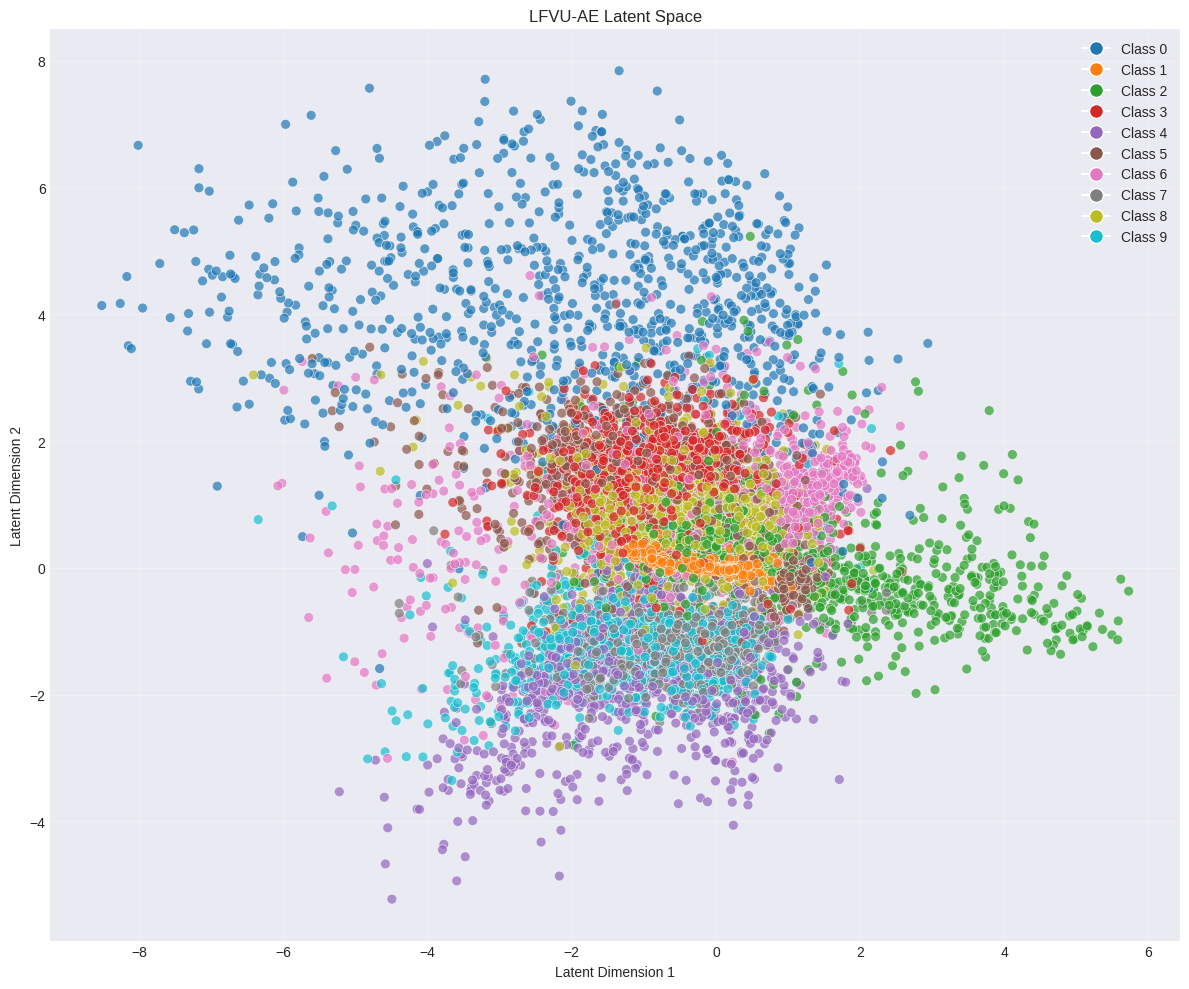

2. Comparing with baseline methods...


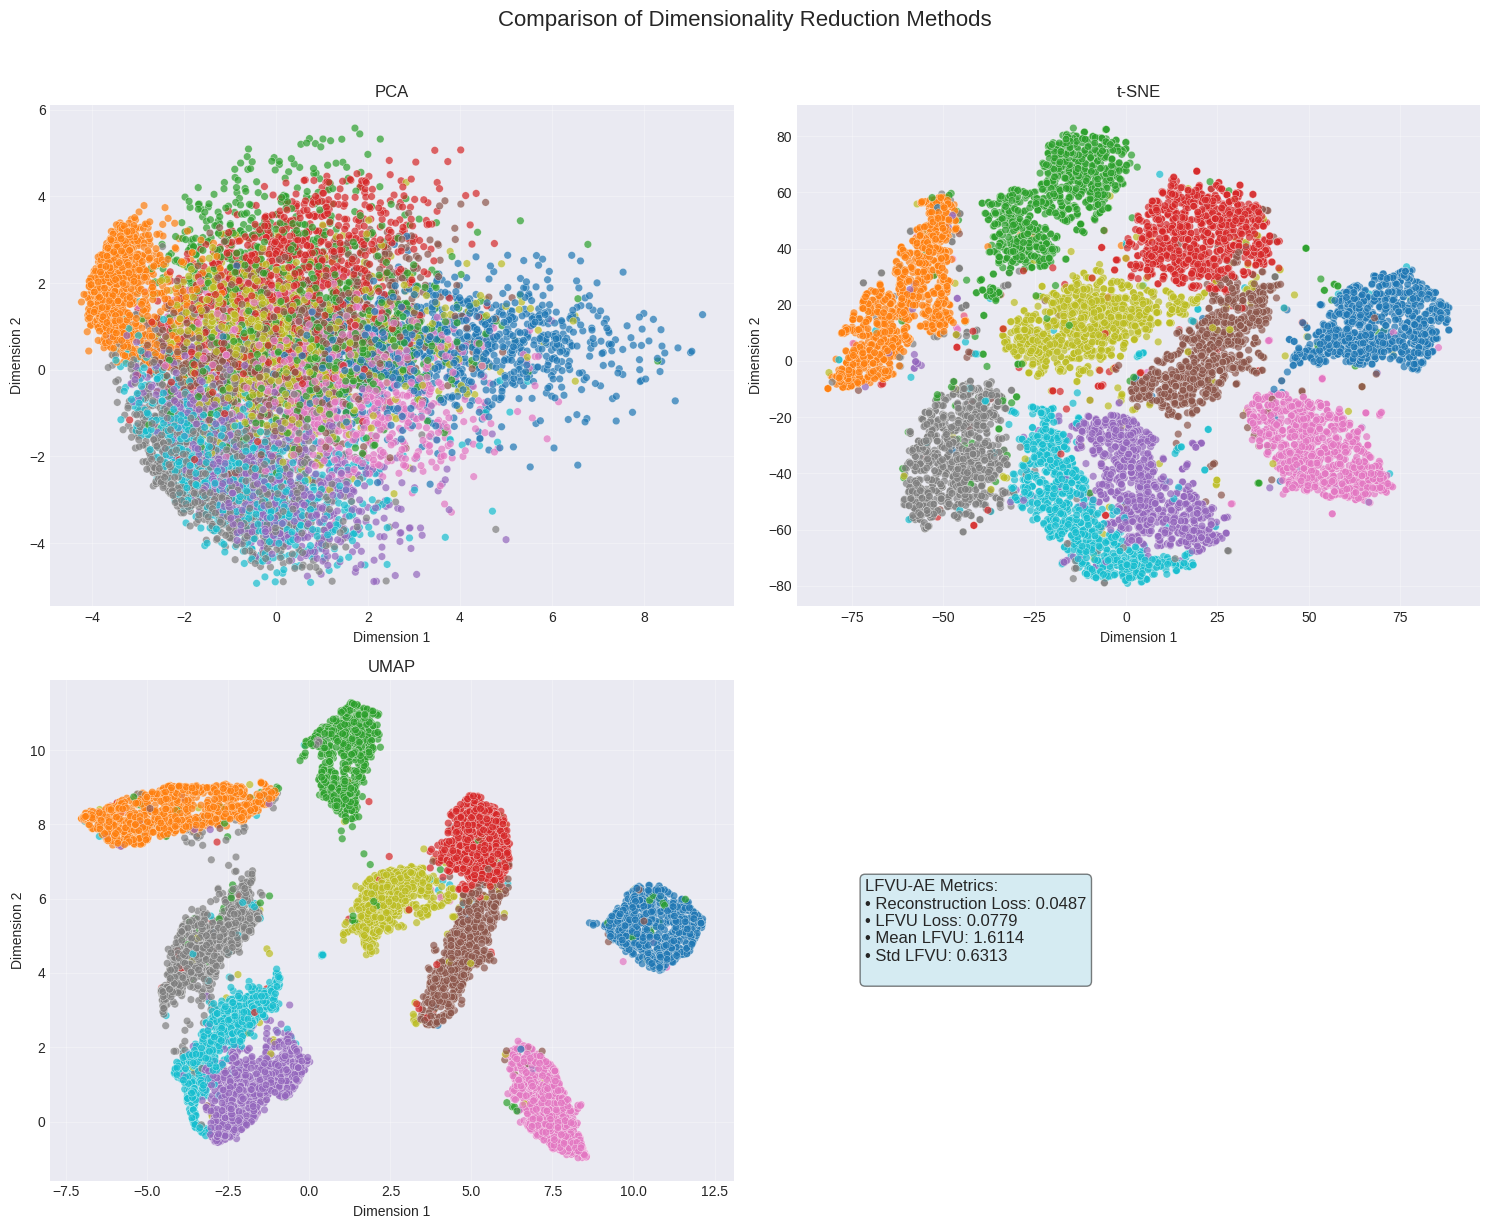

3. Analyzing LFVU distribution...


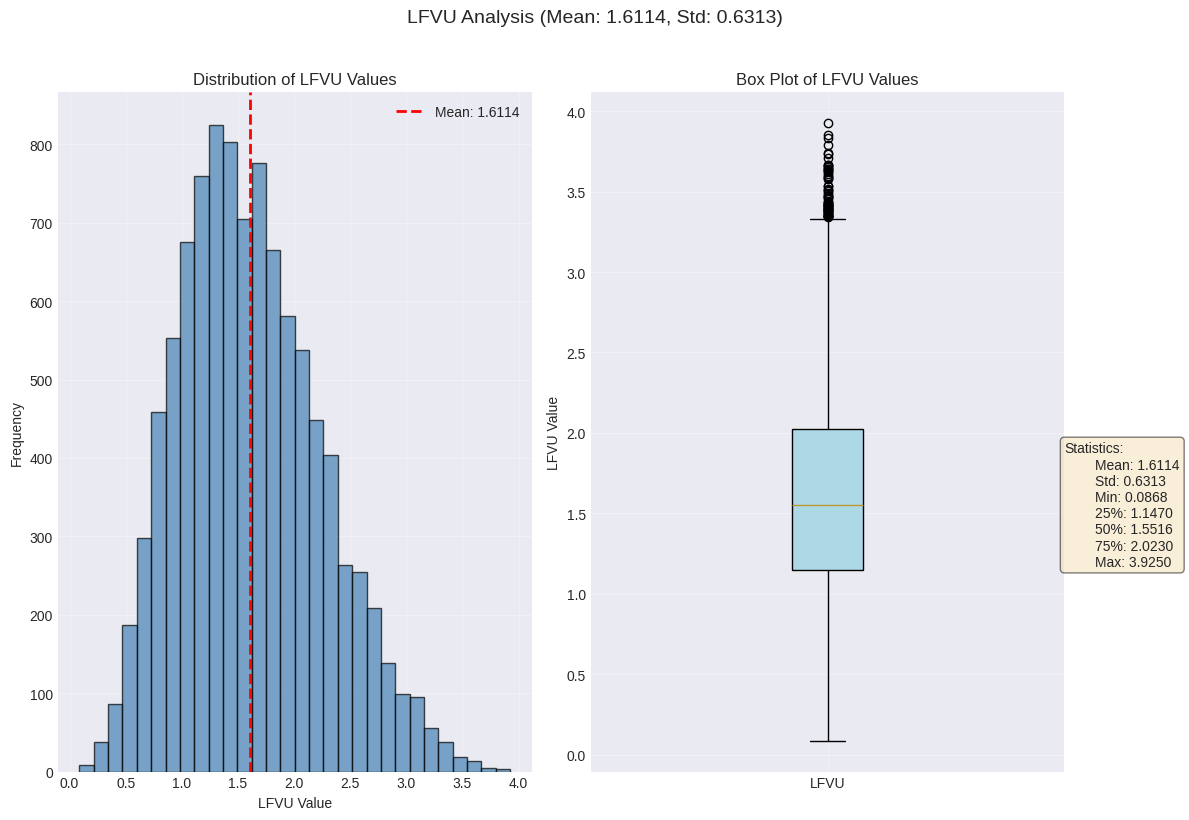

4. Visualizing neighborhood preservation...


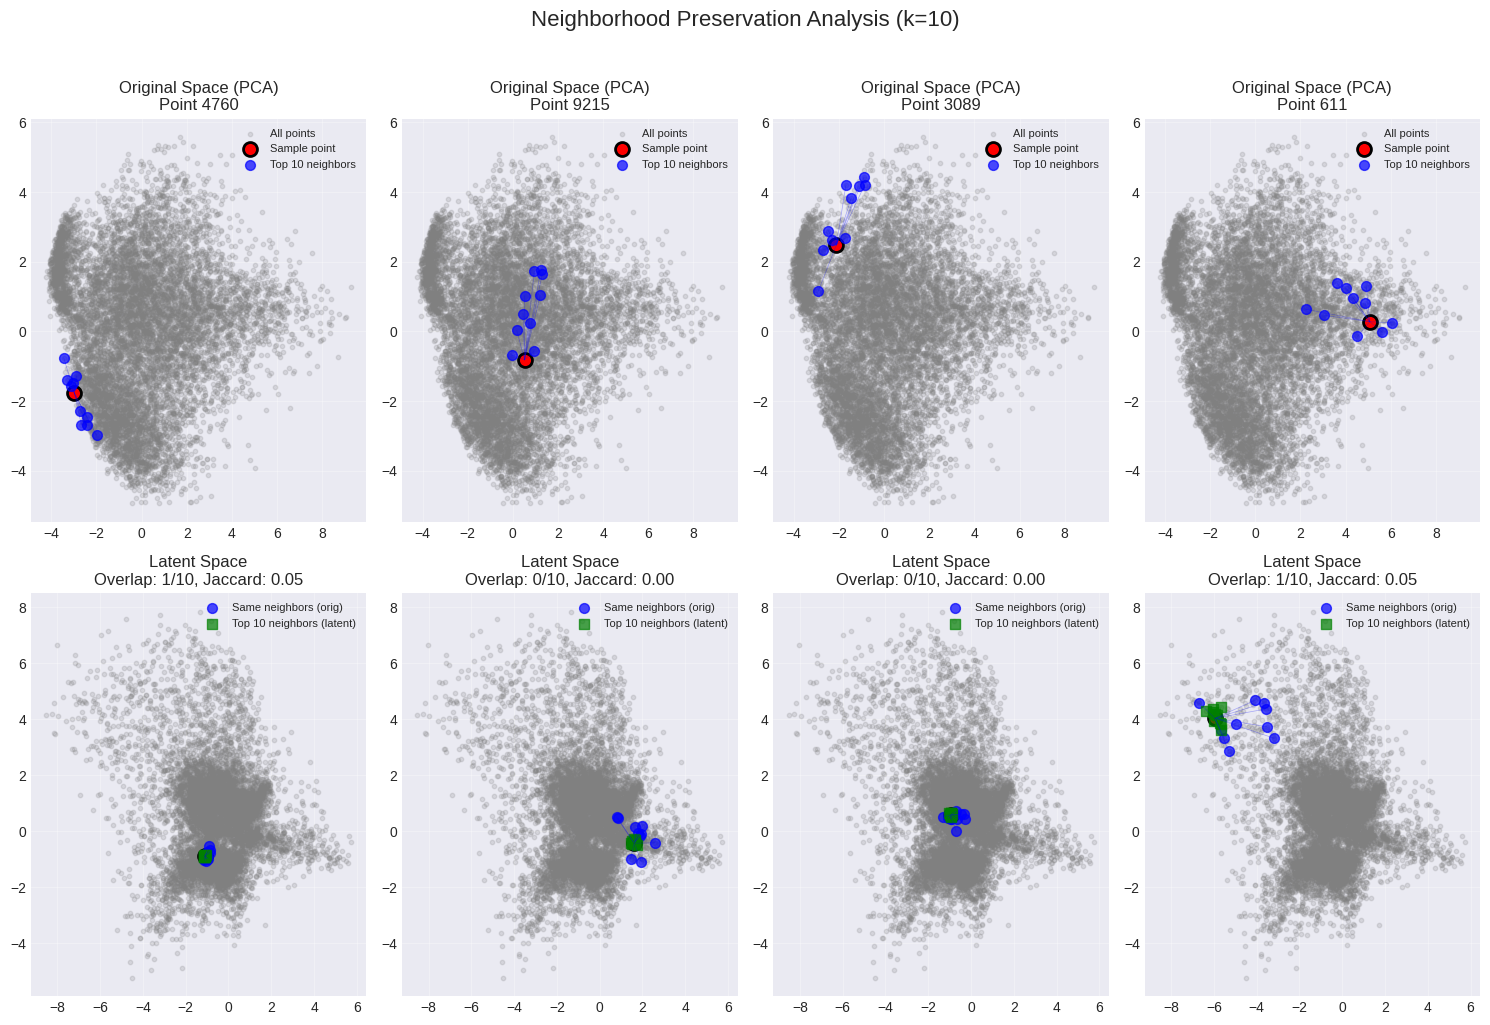

5. Analyzing distance correlation...


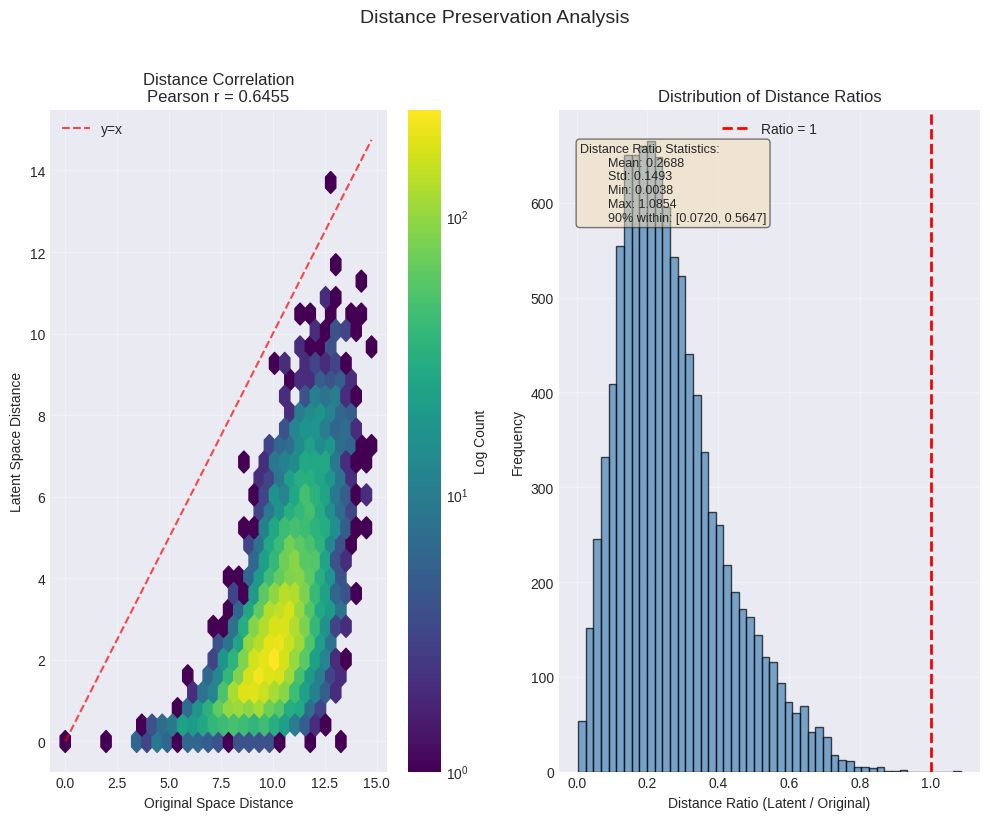

6. Computing metrics...

Report generated in ./lfvu_ae_report_mnist/
Distance correlation: 0.6455
Mean LFVU: 1.6114
Reconstruction loss: 0.0487


In [8]:
    X_test = torch.stack([val_dataset[i][0] for i in range(10000)])
    y_test = torch.tensor([val_dataset[i][1] for i in range(10000)])
    metrics = visualizer.create_comprehensive_report(
        X_test,
        labels=y_test.numpy(),
        output_dir='./lfvu_ae_report_mnist'
    )